# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 12/10/2024

This notebook will try to find good grain orientations from a 4D merge of your peak data.  
This notebook is optimised for a weaker minor phase in a larger major phase sample.  
This means your peaks have been merged across omega and dty.  
This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )
# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [2]:
# import functions we need

import numpy as np
import h5py

import matplotlib
%matplotlib ipympl
from matplotlib import pyplot as plt

import ImageD11.nbGui.nb_utils as utils

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.peakselect import select_ring_peaks_by_intensity, rings_mask

In [3]:
# USER: Pass path to dataset file

dset_file = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

ds = ImageD11.sinograms.dataset.load(dset_file)
   
sample = ds.sample
dataset = ds.dsname
rawdata_path = ds.dataroot
processed_data_root_dir = ds.analysisroot

print(ds)
print(ds.shape)

dataroot = "/data/visitor/ihma439/id11/20231211/RAW_DATA"
analysisroot = "/data/visitor/ihma439/id11/20231211/PROCESSED_DATA/James/20241009"
sample = "FeAu_0p5_tR_nscope"
dset = "top_0um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1
(275, 1448)


In [4]:
# load phases from parameter file

ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': <ImageD11.unitcell.unitcell at 0x7f7def493690>,
 'Fe': <ImageD11.unitcell.unitcell at 0x7f7def493990>}

In [5]:
# now let's select a phase to index from our parameters json
major_phase_str = 'Fe'
minor_phase_str = 'Au'

major_phase_unitcell = ds.phases.unitcells[major_phase_str]
minor_phase_unitcell = ds.phases.unitcells[minor_phase_str]

print(major_phase_str, major_phase_unitcell.lattice_parameters, major_phase_unitcell.spacegroup)
print(minor_phase_str, minor_phase_unitcell.lattice_parameters, minor_phase_unitcell.spacegroup)

Fe [ 2.8694  2.8694  2.8694 90.     90.     90.    ] 229
Au [ 4.0027  4.0027  4.0027 90.     90.     90.    ] 225


In [6]:
# load 4d peaks

cf_4d = ds.get_cf_4d()

Loading existing colfile from /data/visitor/ihma439/id11/20231211/PROCESSED_DATA/James/20241009/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_0um/FeAu_0p5_tR_nscope_top_0um_peaks_4d.h5
Reading your columnfile in hdf format


In [7]:
# for now - set parameters with major phase

ds.update_colfile_pars(cf_4d, phase_name=major_phase_str)

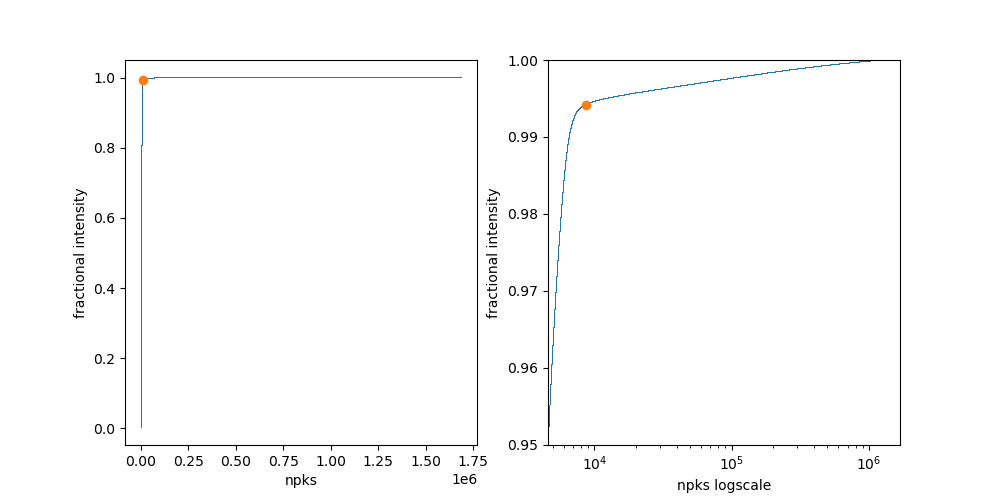

3313288
8650


In [8]:
# here we are filtering our peaks (cf_4d) to select only the strongest ones for indexing purposes only!
# dsmax is being set to limit rings given to the indexer - 6-8 rings is normally good

# USER: modify the "frac" parameter below and re-run the cell until the orange dot sits nicely on the "elbow" of the blue line
# this indicates the fractional intensity cutoff we will select
# if the blue line does not look elbow-shaped in the logscale plot, try changing the "doplot" parameter (the y scale of the logscale plot) until it does

major_phase_cf_frac = 0.99418
major_phase_cf_dsmax = 1.594
major_phase_cf_dstol = 0.0035

cf_major_phase = select_ring_peaks_by_intensity(cf_4d, frac=major_phase_cf_frac, dsmax=major_phase_cf_dsmax, dstol=major_phase_cf_dstol, doplot=0.95)
print(cf_4d.nrows)
print(cf_major_phase.nrows)

In [9]:
# Update geometry for minor phase peaks

ds.update_colfile_pars(cf_4d, phase_name=minor_phase_str)

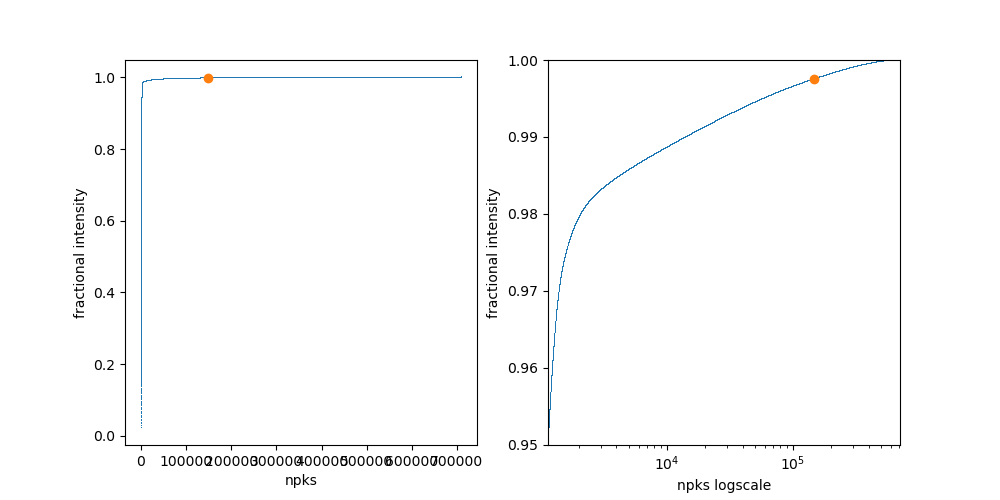

3313288
147669


In [10]:
minor_phase_cf_frac = 0.9975
minor_phase_cf_dsmax = 1.594
minor_phase_cf_dstol = 0.0045

cf_minor_phase = select_ring_peaks_by_intensity(cf_4d, frac=minor_phase_cf_frac, dsmax=minor_phase_cf_dsmax, dstol=minor_phase_cf_dstol, doplot=0.95)
print(cf_4d.nrows)
print(cf_minor_phase.nrows)

In [11]:
major_phase_unitcell.makerings(cf_major_phase.ds.max())
minor_phase_unitcell.makerings(cf_minor_phase.ds.max())

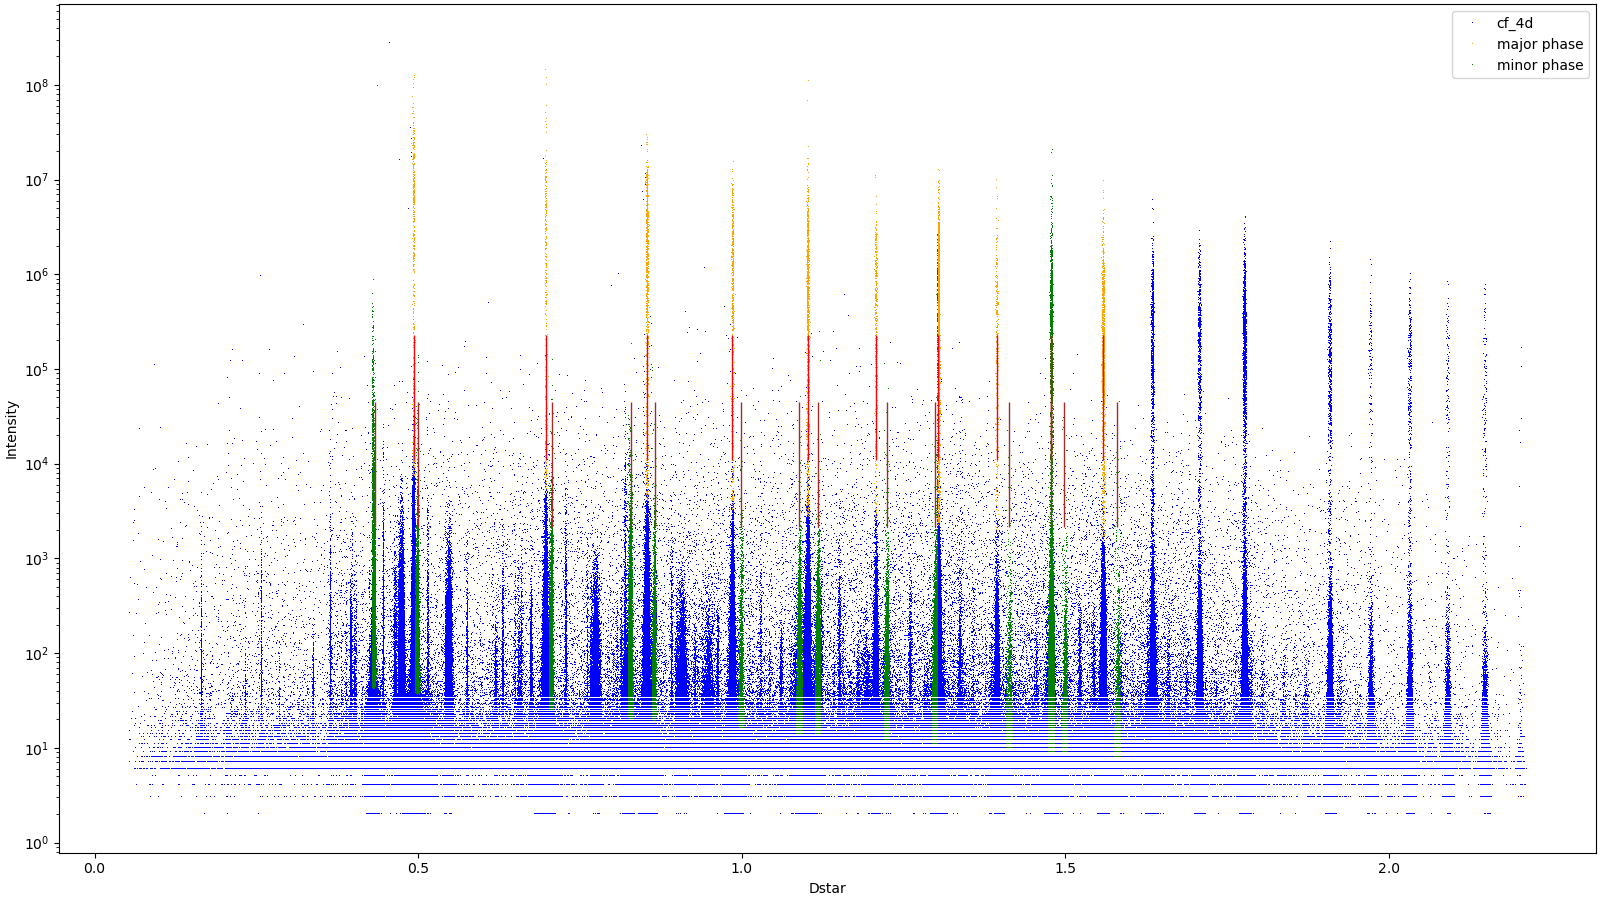

In [12]:
# now we can take a look at the intensities of the remaining peaks

fig, ax = plt.subplots(figsize=(16, 9), constrained_layout=True)

ax.plot(cf_4d.ds, cf_4d.sum_intensity,',', label='cf_4d',c='blue')
ax.plot(cf_major_phase.ds, cf_major_phase.sum_intensity,',', label='major phase',c='orange')
ax.plot(cf_minor_phase.ds, cf_minor_phase.sum_intensity,',', label='minor phase',c='green')
ax.plot(major_phase_unitcell.ringds, [5e4,]*len(major_phase_unitcell.ringds), '|', ms=90, c="red")
ax.plot(minor_phase_unitcell.ringds, [1e4,]*len(minor_phase_unitcell.ringds), '|', ms=90, c="brown")
ax.semilogy()

ax.set_xlabel("Dstar")
ax.set_ylabel("Intensity")
ax.legend()

plt.show()

In [13]:
cf_strong = cf_minor_phase

In [14]:
# specify our ImageD11 indexer with these peaks

indexer = ImageD11.indexing.indexer_from_colfile(cf_strong)

print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[-0.33122421 -0.51243646  1.3460774 ]
 [-0.31636201 -0.86756147 -1.15222898]
 [-0.31634748 -0.87366089 -1.14803199]
 ...
 [-0.36026605 -1.03419208  0.99399945]
 [-0.35252983 -1.03521594  0.99662326]
 [-0.29436223  1.33786706  0.55341578]] (147669, 3) float64
Indexing 147669 peaks


In [15]:
# USER: set a tolerance in d-space (for assigning peaks to powder rings)

indexer_ds_tol = 0.0045
indexer.ds_tol = indexer_ds_tol

# change the log level so we can see what the ring assigments look like

ImageD11.indexing.loglevel = 1

# assign peaks to powder rings

indexer.assigntorings()

# change log level back again

ImageD11.indexing.loglevel = 3

info: Assign to rings, maximum d-spacing considered: 1.584567
info: Ring assignment array shape (147669,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 13  ( -6, -2,  0)   24   1485       0     1485    61     24  25.98
info: Ring 12  (  0,  0, -6)   30   2228       0     2228    73     30  24.63
info: Ring 11  ( -1, -5, -3)   48  70486       0    70486  1452     48  24.28
info: Ring 10  ( -4, -4,  0)   12   1336       0     1336   110     12  23.20
info: Ring 9   ( -1, -1, -5)   32  22969       0    22969   709     32  21.29
info: Ring 8   ( -4, -2, -2)   24   3846       0     3846   158     24  20.06
info: Ring 7   ( -2,  0, -4)   24   4935       0     4935   203     24  18.29
info: Ring 6   ( -3, -3, -1)   24   5471       0     5471   225     24  17.83
info: Ring 5   ( -4,  0,  0)    6   1878       0     1878   309      6  16.35
info: Ring 4   ( -2, -2, -2)    8   2970       0     2970   367      8  14.15
info: Ring 3   ( -1, -1, -3) 

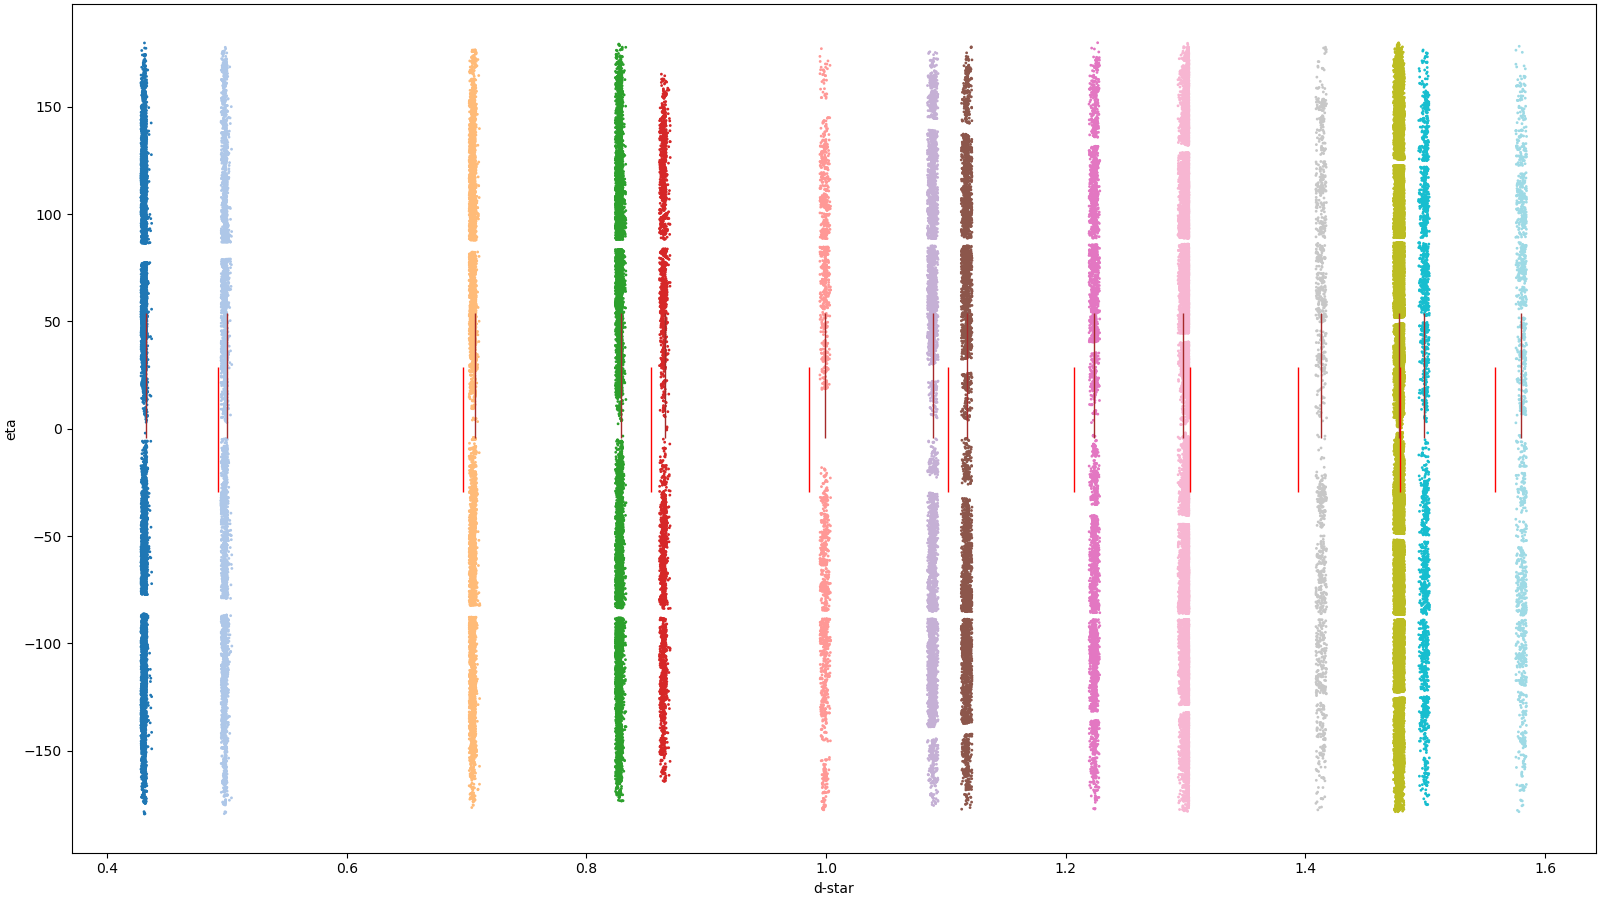

In [16]:
# let's plot the assigned peaks

fig, ax = plt.subplots(layout='constrained', figsize=(16,9))

# indexer.ra is the ring assignments

ax.scatter(cf_strong.ds, cf_strong.eta, c=indexer.ra, cmap='tab20', s=1)
ax.plot( major_phase_unitcell.ringds, [0,]*len(major_phase_unitcell.ringds), '|', ms=90, c="red")
ax.plot( minor_phase_unitcell.ringds, [25,]*len(minor_phase_unitcell.ringds), '|', ms=90, c="brown")

ax.set_xlabel("d-star")
ax.set_ylabel("eta")

plt.show()

In [17]:
# now we are indexing!
# we have to choose which rings we want to generate orientations on
# generally we want two or three low-multiplicity rings that are isolated from other phases
# take a look at the ring assignment output from a few cells above, and choose two or three
rings_for_gen = [0, 4, 5]

# now we want to decide which rings to score our found orientations against
# generally we can just exclude dodgy rings (close to other phases, only a few peaks in etc)
rings_for_scoring = [0, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13]

# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9]
# the tolerance in g-vector angle
cosine_tol = np.cos(np.radians(90 - 0.25))
# the max number of UBIs we can find per pair of rings
max_grains = 1000

grains, indexer = utils.do_index(cf=cf_strong,
                                 unitcell=minor_phase_unitcell,
                                dstol=indexer_ds_tol,
                                forgen=rings_for_gen,
                                foridx=rings_for_scoring,
                                hkl_tols=hkl_tols_seq,
                                fracs=fracs,
                                cosine_tol=cosine_tol,
                                max_grains=max_grains
)
print(f'Found {len(grains)} grains!')

196 peaks expected
Trying these rings (counts, multiplicity, ring number): [(1878, 6, 5), (2970, 8, 4), (8972, 8, 0)]
0.9 0.01 1
0.9 0.02 24
0.9 0.03 61
0.9 0.04 100
0.9 0.05 137
Found 137 grains!


In [18]:
for i, g in enumerate(grains):
    g.a = np.cbrt(np.linalg.det(g.ubi))
    g.gid = i

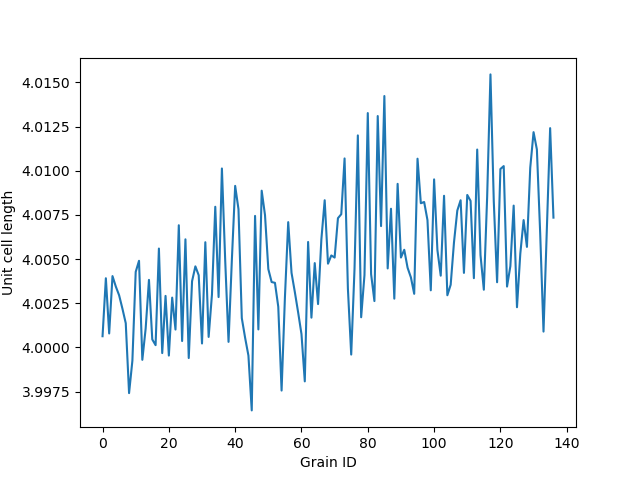

4.004463076479428


In [19]:
mean_unit_cell_lengths = [grain.a for grain in grains]

fig, ax = plt.subplots()
ax.plot(mean_unit_cell_lengths)
ax.set_xlabel("Grain ID")
ax.set_ylabel("Unit cell length")
plt.show()

a0 = np.median(mean_unit_cell_lengths)
    
print(a0)

In [20]:
# assign peaks to grains

peak_assign_tol = 0.05

utils.assign_peaks_to_grains(grains, cf_strong, tol=peak_assign_tol)

Scoring and assigning 137 grains


  0%|          | 0/137 [00:00<?, ?it/s]

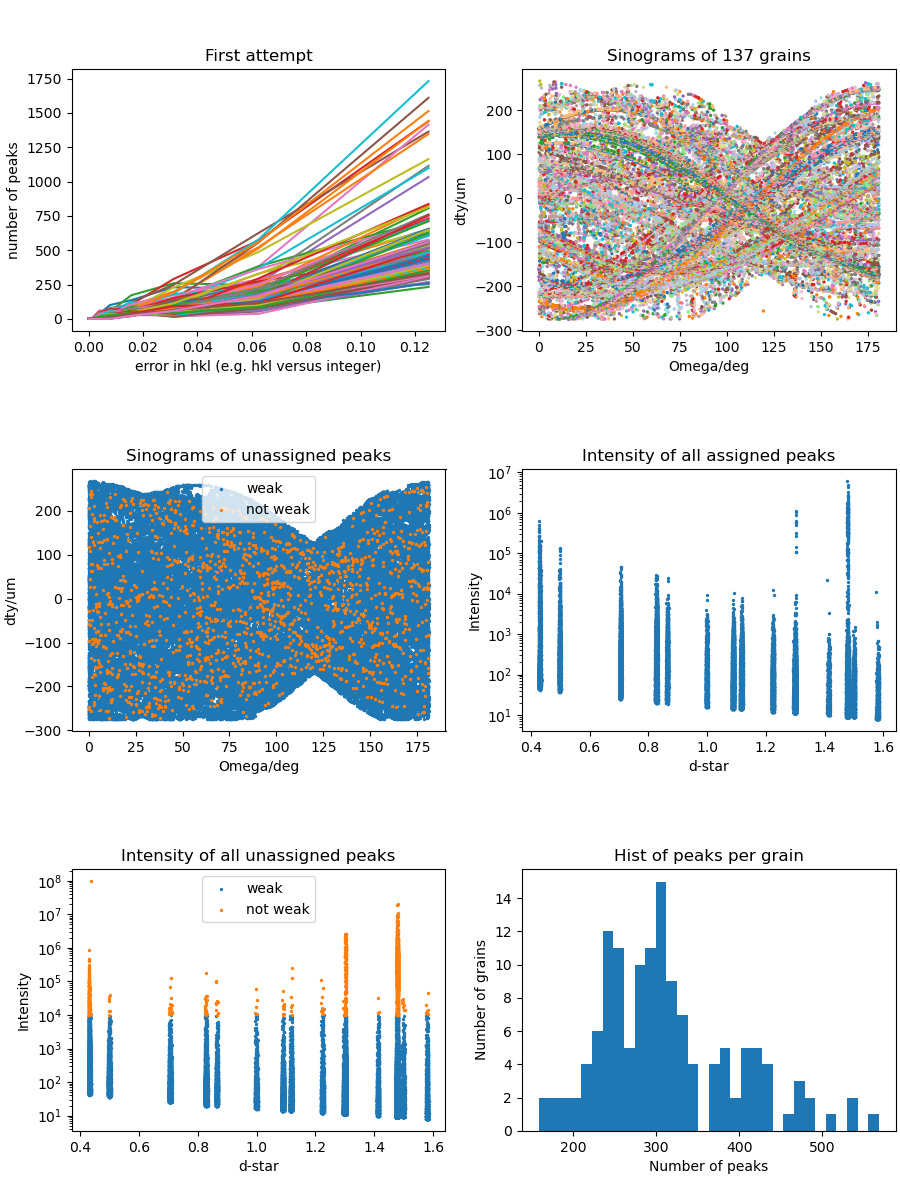

In [21]:
utils.plot_index_results(indexer, cf_strong, 'First attempt')

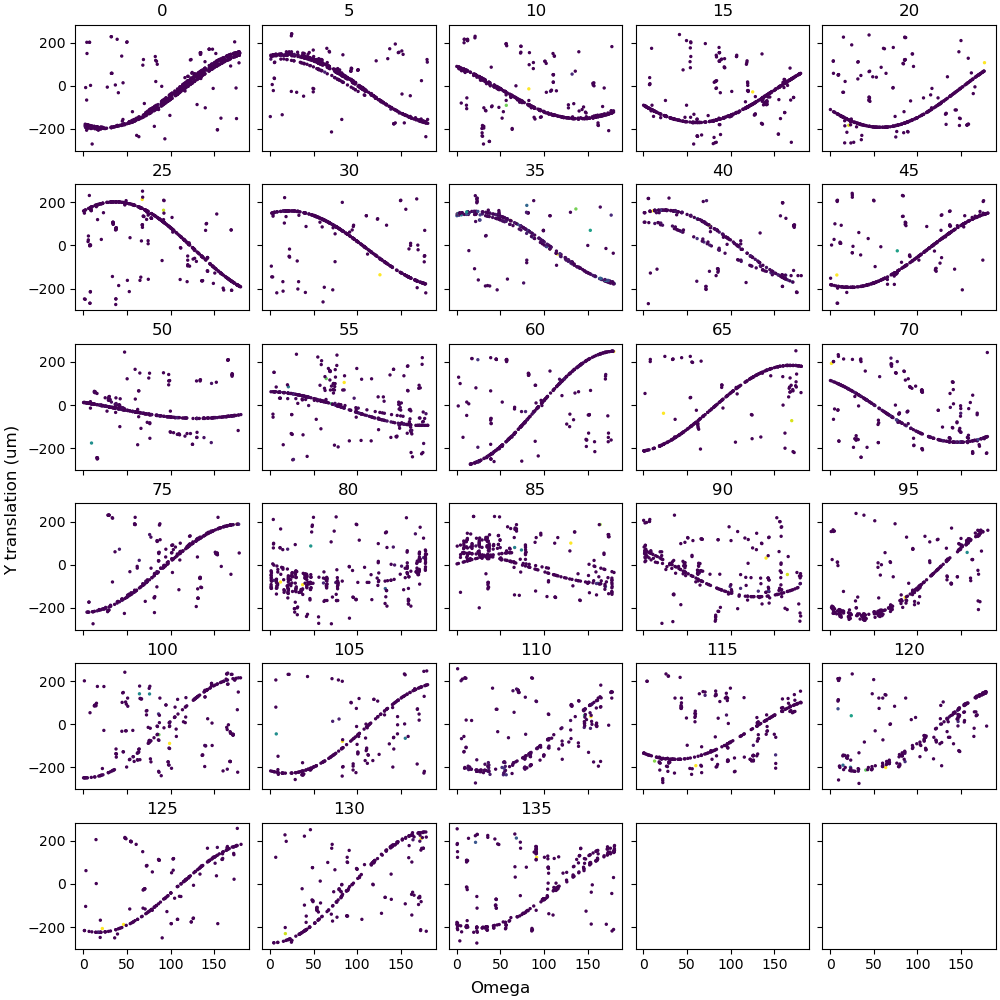

In [22]:
utils.plot_grain_sinograms(grains, cf_strong, 25)

In [23]:
# save grain data

ds.save_grains_to_disk(grains, phase_name=minor_phase_str)

In [24]:
ds.save()

In [ ]:
if 1:
    raise ValueError("Change the 1 above to 0 to allow 'Run all cells' in the notebook")

In [ ]:
# Now that we're happy with our indexing parameters, we can run the below cell to do this in bulk for many samples/datasets
# by default this will do all samples in sample_list, all datasets with a prefix of dset_prefix
# you can add samples and datasets to skip in skips_dict

skips_dict = {
    "FeAu_0p5_tR_nscope": ["top_-50um", "top_-100um"]
}

dset_prefix = "top"

sample_list = ["FeAu_0p5_tR_nscope"]
    
samples_dict = utils.find_datasets_to_process(rawdata_path, skips_dict, dset_prefix, sample_list)
    
# manual override:
# samples_dict = {"FeAu_0p5_tR_nscope": ["top_100um", "top_150um"]}
    
# now we have our samples_dict, we can process our data:

for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
        if not os.path.exists(dset_path):
            print(f"Missing DataSet file for {dataset} in sample {sample}, skipping")
            continue
        
        print("Importing DataSet object")
        
        ds = ImageD11.sinograms.dataset.load(dset_path)
        print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
        
        ds.phases = ds.get_phases_from_disk()
        
        if os.path.exists(ds.grainsfile):
            # check grains file for existance of minor phase, skip if it's there
            with h5py.File(ds.grainsfile, "r") as hin:
                if minor_phase_str in hin.keys():
                    print(f"Already have grains for {dataset} in sample {sample}, skipping")
                    continue
        
        cf_4d = ds.get_cf_4d()
        ds.update_colfile_pars(cf_4d, phase_name=minor_phase_str)
        
        cf_strong = select_ring_peaks_by_intensity(cf_4d, dstol=minor_phase_cf_dstol, dsmax=minor_phase_cf_dsmax, frac=minor_phase_cf_frac)

        grains, indexer = utils.do_index(cf=cf_strong,
                                         unitcell=ds.phases.unitcells[minor_phase_str],
                                         dstol=indexer_ds_tol,
                                         forgen=rings_for_gen,
                                         foridx=rings_for_scoring,
                                         hkl_tols=hkl_tols_seq,
                                         fracs=fracs,
                                         cosine_tol=cosine_tol,
                                         max_grains=max_grains
        )

        ds.save_grains_to_disk(grains, phase_name=minor_phase_str)
        ds.save()

print("Done!")